# 1. Preliminary

## 1.1 Context

* We will perform a modelisation based on the Kaggle project : tweets from disaster


* It is a Kaggle competition, which offers a simple but good level textual dataset to be able to make its weapons in NLP


* Please have a look to the first part of the TP

## 1.2 Imports

In [246]:
# builtin
import os, sys, time, random


# data
import pandas as pd
import numpy as np


# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import spacy


# ML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD , PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


# viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
from wordcloud import WordCloud
from PIL import Image


# parallelisation
from pandarallel import pandarallel

## 1.3 Downloads and options

In [247]:
# init sns

sns.set()

## 1.4 Loading data

In [248]:
# our file

data = "./data/cleaned/"
os.listdir(data)

['min_10_words.csv',
 'min_5_words.csv',
 'final_df.csv',
 'df_cleaned.csv',
 'unique_words.csv']

In [249]:
# load dataframe

fn = data + 'final_df.csv'
df = pd.read_csv(fn)
df

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,reason earthquak may allah
1,Forest fire near La Ronge Sask. Canada,1,forest fire near canada
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place offic evacu shelter pl...
3,"13,000 people receive #wildfires evacuation or...",1,wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo alaska smoke wildfir school
...,...,...,...
7498,#WorldNews Fallen powerlines on G:link tram: U...,1,link tram updat fire crew evacu passeng
7499,on the flip side I'm at Walmart and there is a...,1,side bomb everyon evacu stay blow
7500,Suicide bomber kills 15 in Saudi security site...,1,suicid bomber kill secur site mosqu world news...
7501,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home


In [250]:
# NaN

df.isna().sum()

text           0
target         0
clean_text    54
dtype: int64

In [251]:
# dropna 

df = df.dropna()
df.isna().sum()

text          0
target        0
clean_text    0
dtype: int64

In [252]:
df.shape

(7449, 3)

# 2. Data Preparation

## 2.1 X & y

In [253]:
X = df.clean_text
y = df.target

In [254]:
X.head()

0                           reason earthquak may allah
1                              forest fire near canada
2    resid ask shelter place offic evacu shelter pl...
3                       wildfir evacu order california
4           got sent photo alaska smoke wildfir school
Name: clean_text, dtype: object

In [255]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

## 2.2 Test-train split

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size=0.25, 
                                                   random_state=42)

In [271]:
print(f"X_train : {X_train.shape}, y_train {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test {y_test.shape}")

X_train : (5586,), y_train (5586,)
X_test : (1863,), y_test (1863,)


## 2.3 CountVectorizer

In [272]:
data = ["le chien est vert", 
        "le chien est rouge", 
        "le chien est bleu, vraiment très bleu", 
        "vert, vert, vert, vert, le chien est vert, vraiment vert"]

In [273]:
vect = CountVectorizer()
data_C = vect.fit_transform(data)
data_C

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [274]:
data_C = pd.DataFrame(data_C.toarray(), columns=vect.get_feature_names_out())
data_C

,bleu,chien,est,le,rouge,très,vert,vraiment
0,0,1,1,1,0,0,1,0
1,0,1,1,1,1,0,0,0
2,2,1,1,1,0,1,0,1
3,0,1,1,1,0,0,6,1


In [275]:
data_C.describe().describe().T.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
vert,8.0,2.171535,2.101036,0.0,0.375,2.000000,3.154211,6.0
bleu,8.0,1.000000,1.388730,0.0,0.000,0.500000,1.250000,4.0
rouge,8.0,0.750000,1.356203,0.0,0.000,0.250000,0.625000,4.0
très,8.0,0.750000,1.356203,0.0,0.000,0.250000,0.625000,4.0
vraiment,8.0,0.947169,1.290421,0.0,0.375,0.538675,1.000000,4.0
chien,8.0,1.250000,1.164965,0.0,1.000,1.000000,1.000000,4.0
est,8.0,1.250000,1.164965,0.0,1.000,1.000000,1.000000,4.0
le,8.0,1.250000,1.164965,0.0,1.000,1.000000,1.000000,4.0


In [276]:
scaler = StandardScaler()
data_c_scaled = scaler.fit_transform(data_C)
data_c_scaled = pd.DataFrame(data_c_scaled, columns=vect.get_feature_names_out()).round(4)
data_c_scaled.describe().T.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
bleu,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
rouge,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
très,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
vert,4.0,0.000025,1.154706,-0.7035,-0.7035,-0.5025,0.201025,1.7086
vraiment,4.0,0.000000,1.154701,-1.0000,-1.0000,0.0000,1.000000,1.0000
chien,4.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000
est,4.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000
le,4.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000


In [277]:
vect = CountVectorizer()
X_train_c = vect.fit_transform(X_train)
X_train_c = pd.DataFrame(X_train_c.toarray(), columns=vect.get_feature_names_out())
X_train_c.head()

,aba,abandon,abl,ablaz,absolut,absurdli,access,accid,accident,accord,...,year,yelp,yesterday,yet,york,young,youth,yr,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
X_train_c.shape

(5586, 1615)

In [279]:
X_test_c = vect.transform(X_test)
X_test_c = pd.DataFrame(X_test_c.toarray(), columns=vect.get_feature_names_out())
X_test_c.head()

,aba,abandon,abl,ablaz,absolut,absurdli,access,accid,accident,accord,...,year,yelp,yesterday,yet,york,young,youth,yr,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [280]:
X_test_c.shape

(1863, 1615)

## 2.4 TfidfVectorizer

In [281]:
vect = TfidfVectorizer()
data_T = vect.fit_transform(data)
data_T

<4x8 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [282]:
data_T = pd.DataFrame(data_T.toarray(), columns=vect.get_feature_names_out())
data_T

,bleu,chien,est,le,rouge,très,vert,vraiment
0,0.000000,0.435087,0.435087,0.435087,0.00000,0.0000,0.657341,0.000000
1,0.000000,0.387139,0.387139,0.387139,0.74187,0.0000,0.000000,0.000000
2,0.788199,0.205658,0.205658,0.205658,0.00000,0.3941,0.000000,0.310713
3,0.000000,0.106931,0.106931,0.106931,0.00000,0.0000,0.969328,0.161555


In [283]:
data_T.describe().T.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
vert,4.0,0.406667,0.486546,0.000000,0.000000,0.328671,0.735338,0.969328
bleu,4.0,0.197050,0.394100,0.000000,0.000000,0.000000,0.197050,0.788199
rouge,4.0,0.185468,0.370935,0.000000,0.000000,0.000000,0.185468,0.741870
très,4.0,0.098525,0.197050,0.000000,0.000000,0.000000,0.098525,0.394100
chien,4.0,0.283704,0.153791,0.106931,0.180976,0.296398,0.399126,0.435087
est,4.0,0.283704,0.153791,0.106931,0.180976,0.296398,0.399126,0.435087
le,4.0,0.283704,0.153791,0.106931,0.180976,0.296398,0.399126,0.435087
vraiment,4.0,0.118067,0.149313,0.000000,0.000000,0.080777,0.198844,0.310713


In [284]:
scaler = StandardScaler()
data_t_scaled = scaler.fit_transform(data_T)
data_t_scaled = pd.DataFrame(data_t_scaled, columns=vect.get_feature_names_out()).round(4)
data_t_scaled.describe().T.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
bleu,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
rouge,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
très,4.0,-0.000025,1.154750,-0.5774,-0.5774,-0.5774,-0.000025,1.7321
vraiment,4.0,-0.000025,1.154716,-0.9131,-0.9131,-0.2884,0.624675,1.4898
chien,4.0,0.000000,1.154675,-1.3272,-0.7713,0.0953,0.866600,1.1366
est,4.0,0.000000,1.154675,-1.3272,-0.7713,0.0953,0.866600,1.1366
le,4.0,0.000000,1.154675,-1.3272,-0.7713,0.0953,0.866600,1.1366
vert,4.0,0.000000,1.154667,-0.9651,-0.9651,-0.1851,0.780000,1.3353


In [285]:
vect = TfidfVectorizer()
X_train_t = vect.fit_transform(X_train)
X_train_t = pd.DataFrame(X_train_t.toarray(), columns=vect.get_feature_names_out())
X_train_t.head()

,aba,abandon,abl,ablaz,absolut,absurdli,access,accid,accident,accord,...,year,yelp,yesterday,yet,york,young,youth,yr,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
X_train_t.shape

(5586, 1615)

In [287]:
X_test_t = vect.transform(X_test)
X_test_t = pd.DataFrame(X_test_t.toarray(), columns=vect.get_feature_names_out())
X_test_t.head()

,aba,abandon,abl,ablaz,absolut,absurdli,access,accid,accident,accord,...,year,yelp,yesterday,yet,york,young,youth,yr,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [288]:
X_test_t.shape

(1863, 1615)

# 3. Modelisation

## 3.1 Raw Modelisation

In [289]:
estimator = KNeighborsClassifier()
param_grid = {}
cv = 10

In [290]:
grid = GridSearchCV(estimator, 
                    param_grid, 
                    cv=cv, 
                    n_jobs=-1, 
                    return_train_score=True, 
                    verbose=1)

# grid.fit(X_train_c, y_train)

In [291]:
def modelize(X_,
             y_, 
             estimator, 
             param_grid={},
             cv=10): 
    
    grid = GridSearchCV(estimator, 
                        param_grid, 
                        cv=cv, 
                        n_jobs=-1, 
                        return_train_score=True, 
                        verbose=1)

    grid.fit(X_, y_)
    
    return grid
    

In [292]:
grid = modelize(X_train_c, y_train, estimator)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [293]:
res = pd.DataFrame(grid.cv_results_)
cols = [i for i in res.columns if "split" not in i ]
res = res[cols]
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.082512,0.020685,0.651545,0.170312,{},0.728247,0.012474,1,0.804491,0.002113


In [294]:
def resultize(grid) : 
    
    res = pd.DataFrame(grid.cv_results_)
    cols = [i for i in res.columns if "split" not in i ]
    res = res[cols]
    
    return res.sort_values("rank_test_score")

In [295]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.082512,0.020685,0.651545,0.170312,{},0.728247,0.012474,1,0.804491,0.002113


In [296]:
grid = modelize(X_train_c, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.050116,0.004804,0.616718,0.140679,{},0.728247,0.012474,1,0.804491,0.002113


In [297]:
grid = modelize(X_train_t, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.049425,0.008688,0.500632,0.116131,{},0.75939,0.026217,1,0.827306,0.002304


## 3.2 With scaled data

In [298]:
X_train_c_scaled = StandardScaler().fit_transform(X_train_c)
grid = modelize(X_train_c_scaled, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.046847,0.00719,0.512193,0.085324,{},0.721441,0.02308,1,0.805864,0.004813


In [299]:
X_train_t_scaled = StandardScaler().fit_transform(X_train_t)
grid = modelize(X_train_t_scaled, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.052729,0.009257,0.517503,0.091977,{},0.725913,0.022309,1,0.811374,0.004527


## 3.3 With PCA

In [300]:
pca = PCA()
X_train_c_pca = pca.fit_transform(X_train_c)

In [301]:
pca.explained_variance_ratio_

array([1.16053606e-02, 8.94057613e-03, 8.87442652e-03, ...,
       2.28727249e-33, 1.28254337e-34, 3.71472373e-35])

In [302]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum)+1), cumsum)

1615

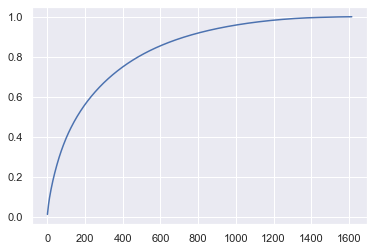

In [305]:
X_train_c_pca = X_train_c_pca[:, :450]
X_train_c_pca.shape

In [308]:
grid = modelize(X_train_c_pca, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.02085,0.006652,0.201074,0.055575,{},0.727886,0.017552,1,0.812468,0.006162


Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.061464,0.015577,0.553042,0.128327,{},0.721441,0.02308,1,0.805864,0.004813


In [309]:
pca = PCA()
X_train_t_pca = pca.fit_transform(X_train_t)

In [310]:
pca.explained_variance_ratio_

array([6.38260358e-03, 5.78466590e-03, 5.62350108e-03, ...,
       9.31496592e-33, 7.98563066e-34, 1.65368830e-35])

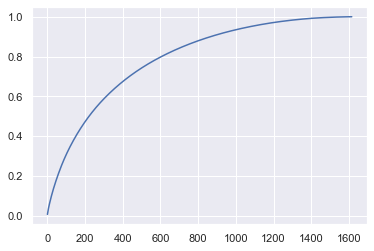

In [311]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum)+1), cumsum)

In [315]:
X_train_t_pca = X_train_t_pca[:, :600]
X_train_t_pca.shape

(5586, 600)

In [316]:
grid = modelize(X_train_t_pca, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.023634,0.00525,0.203149,0.04543,{},0.713746,0.022653,1,0.845825,0.019902


## 3.3 With and scaling PCA

In [318]:
pca = PCA()
X_train_c_scaled_pca = pca.fit_transform(X_train_c_scaled)

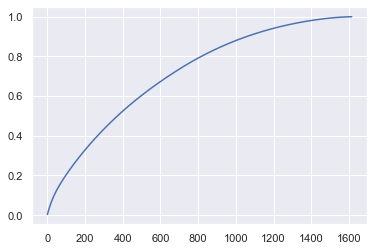

In [319]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum)+1), cumsum)

In [321]:
X_train_c_scaled_pca = X_train_c_scaled_pca[:, :800]
X_train_c_scaled_pca.shape

(5586, 800)

In [322]:
grid = modelize(X_train_c_scaled_pca, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.057376,0.017944,0.257314,0.054234,{},0.722519,0.012142,1,0.811254,0.004777


In [323]:
pca = PCA()
X_train_t_scaled_pca = pca.fit_transform(X_train_t_scaled)

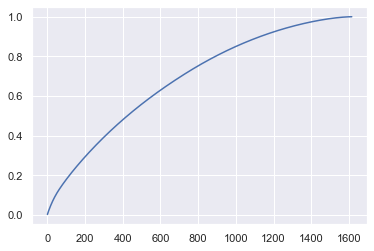

In [324]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum)+1), cumsum)

In [325]:
X_train_t_scaled_pca = X_train_t_scaled_pca[:, :800]
X_train_t_scaled_pca.shape

(5586, 800)

In [326]:
grid = modelize(X_train_c_scaled_pca, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.030789,0.004335,0.253649,0.056807,{},0.722519,0.012142,1,0.811254,0.004777


## 2.4 TSVD

In [330]:
tcd = TruncatedSVD(n_components=30)
X_train_c_tcd = tcd.fit_transform(X_train_c)

In [331]:
grid = modelize(X_train_tcd, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.001324,0.000317,0.025019,0.006679,{},0.733078,0.011655,1,0.813999,0.003115


In [332]:
tcd = TruncatedSVD(n_components=30)
X_train_t_tcd = tcd.fit_transform(X_train_t)

In [333]:
grid = modelize(X_train_t_tcd, y_train, estimator)
resultize(grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.002521,0.002669,0.028826,0.008167,{},0.73165,0.009882,1,0.810837,0.002288


In [334]:
pipe = Pipeline([
    ("reduction", TruncatedSVD()), 
    ("estimator", KNeighborsClassifier()),
     ])

In [40]:
scaler_list = [StandardScaler()]

In [343]:
n_components = np.linspace(2, 40, 20).astype(int)
n_components

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40])

In [344]:
param_grid = { "reduction" : [TruncatedSVD()], 
               "estimator" : [KNeighborsClassifier()], 
               "reduction__n_components": n_components, 
               "estimator__n_neighbors" : range(2, 12, 2) 
             }

In [345]:
grid = modelize(X_train_t_tcd, y_train, pipe, param_grid=param_grid)
res  = resultize(grid)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/Users/alexandre.gazagnes/Desktop/cours/fr/analysez-des-donnes-textuelles/partie-1/tp/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
250 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alexandre.gazagnes/Desktop/cours/fr/analysez-des-donnes-textuelles/partie-1/tp/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alexandre.gazagnes/Desktop/cours/fr/analysez-des-donnes-textuelles/partie-1/tp/env/lib/python3.10/site-packages/sklearn/pipeline.py", line 3

In [348]:
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__n_neighbors,param_reduction,param_reduction__n_components,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
51,0.035875,0.005811,0.025133,0.005617,KNeighborsClassifier(n_neighbors=6),6,TruncatedSVD(n_components=24),24,{'estimator': KNeighborsClassifier(n_neighbors...,0.738275,0.010801,1,0.789155,0.003496
74,0.031646,0.006198,0.030070,0.005133,KNeighborsClassifier(n_neighbors=6),8,TruncatedSVD(n_components=24),30,{'estimator': KNeighborsClassifier(n_neighbors...,0.737916,0.013715,2,0.778315,0.001910
73,0.031558,0.005136,0.030706,0.004270,KNeighborsClassifier(n_neighbors=6),8,TruncatedSVD(n_components=24),28,{'estimator': KNeighborsClassifier(n_neighbors...,0.737378,0.017646,3,0.777161,0.002528
94,0.032174,0.007438,0.032546,0.004741,KNeighborsClassifier(n_neighbors=6),10,TruncatedSVD(n_components=24),30,{'estimator': KNeighborsClassifier(n_neighbors...,0.736305,0.012429,4,0.771751,0.001919
50,0.029094,0.006624,0.031294,0.007708,KNeighborsClassifier(n_neighbors=6),6,TruncatedSVD(n_components=24),22,{'estimator': KNeighborsClassifier(n_neighbors...,0.735767,0.014294,5,0.789772,0.002207


In [347]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [45]:
grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, return_train_score=True, verbose=3)
grid.fit(X, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('reduction', TruncatedSVD()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'estimator': [RandomForestClassifier()],
                         'reduction': [TruncatedSVD(n_components=94)],
                         'reduction__n_components': array([  2,   7,  12,  17,  22,  27,  32,  38,  43,  48,  53,  58,  63,
        69,  74,  79,  84,  89,  94, 100])},
             return_train_score=True, verbose=3)

In [46]:
res = pd.DataFrame(grid.cv_results_)
cols = [i for i in res.columns if "split" not in i ]
res = res[cols]
res.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reduction,param_reduction__n_components,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
18,8.297146,0.179732,0.104479,0.011208,RandomForestClassifier(),TruncatedSVD(n_components=94),94,"{'estimator': RandomForestClassifier(), 'reduc...",0.772195,0.004382,1,0.980415,0.000573
19,7.453844,0.950840,0.066929,0.016220,RandomForestClassifier(),TruncatedSVD(n_components=94),100,"{'estimator': RandomForestClassifier(), 'reduc...",0.770370,0.006810,2,0.980415,0.000573
15,6.954813,0.143970,0.101653,0.010261,RandomForestClassifier(),TruncatedSVD(n_components=94),79,"{'estimator': RandomForestClassifier(), 'reduc...",0.769941,0.006921,3,0.980272,0.000624
12,6.247024,0.077220,0.095330,0.010359,RandomForestClassifier(),TruncatedSVD(n_components=94),63,"{'estimator': RandomForestClassifier(), 'reduc...",0.769941,0.006597,4,0.980201,0.000626
16,7.641625,0.101980,0.109409,0.018464,RandomForestClassifier(),TruncatedSVD(n_components=94),84,"{'estimator': RandomForestClassifier(), 'reduc...",0.769189,0.007469,5,0.980344,0.000634
9,4.978319,0.194578,0.100025,0.018247,RandomForestClassifier(),TruncatedSVD(n_components=94),48,"{'estimator': RandomForestClassifier(), 'reduc...",0.768867,0.006456,6,0.980165,0.000654
13,6.696014,0.042125,0.094418,0.012222,RandomForestClassifier(),TruncatedSVD(n_components=94),69,"{'estimator': RandomForestClassifier(), 'reduc...",0.768760,0.005209,7,0.980201,0.000626
17,7.945547,0.124245,0.113679,0.018249,RandomForestClassifier(),TruncatedSVD(n_components=94),89,"{'estimator': RandomForestClassifier(), 'reduc...",0.768438,0.007310,8,0.980308,0.000599
10,6.095293,0.108542,0.096674,0.008474,RandomForestClassifier(),TruncatedSVD(n_components=94),53,"{'estimator': RandomForestClassifier(), 'reduc...",0.767901,0.009170,9,0.980201,0.000626
14,6.680552,0.121103,0.102307,0.012871,RandomForestClassifier(),TruncatedSVD(n_components=94),74,"{'estimator': RandomForestClassifier(), 'reduc...",0.767794,0.006302,10,0.980308,0.000599


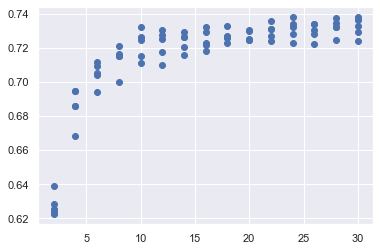

In [349]:
plt.scatter(res.param_reduction__n_components, res.mean_test_score)

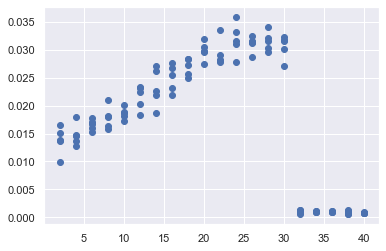

In [350]:
plt.scatter(res.param_reduction__n_components, res.mean_fit_time)